In [10]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [11]:
# Load the SQLite database file
db_path = r'C:\Users\calua\OneDrive - Vodafone Group\Desktop\3Signet\Abc Project\ABC_pharm_data.db'

# Connect to the SQLite database
conn = sqlite3.connect(db_path)

# Load relevant tables into DataFrames
fact_sales_df = pd.read_sql("SELECT * FROM fact_sales;", conn)
dim_product_df = pd.read_sql("SELECT * FROM dim_product;", conn)
dim_customer_df = pd.read_sql("SELECT * FROM dim_customer;", conn)

# Merge the fact_sales table with dim_product to analyze product trends
sales_data = pd.merge(fact_sales_df, dim_product_df, on="ProductName", how="left")

# Group by year and product to analyze trends
sales_by_year_product = sales_data.groupby(["Year", "ProductName"]).agg(
    Total_Sales=("Sales", "sum"),
    Total_Quantity=("Quantity", "sum")
).reset_index()

# Group by product class to analyze lifecycle and sales distribution
product_performance = sales_data.groupby("ProductClass").agg(
    Total_Sales=("Sales", "sum"),
    Average_Price=("Price", "mean"),
    Total_Quantity=("Quantity", "sum")
).reset_index()

# Display the results
print("Sales Data Trends by Year and Product:")
print(sales_by_year_product)

print("\nProduct Performance Trends:")
print(product_performance)


Sales Data Trends by Year and Product:
     Year            ProductName  Total_Sales  Total_Quantity
0    2017           Abatatriptan   19036010.0         25655.0
1    2017     Abilovir Aprotasol    7155131.0         26599.0
2    2017             Abobozolid    1297800.0         17304.0
3    2017  Abranatal Lysoprosate   17662416.0         25936.0
4    2017                Abtasol   11564852.0         15338.0
..    ...                    ...          ...             ...
955  2020             Zithrotrol    3037838.0         22174.0
956  2020              Zonitonin   10303538.0         19891.0
957  2020   Zonixamine Immulinum    7365666.0         24717.0
958  2020               Zynosine    1583822.0         21403.0
959  2020                Zyvance    7624738.0         23606.0

[960 rows x 4 columns]

Product Performance Trends:
       ProductClass   Total_Sales  Average_Price  Total_Quantity
0        Analgesics  2.371515e+09     432.571071    5.553144e+06
1       Antibiotics  1.750277e+09 

## 1. Sales Trends by Year and Product

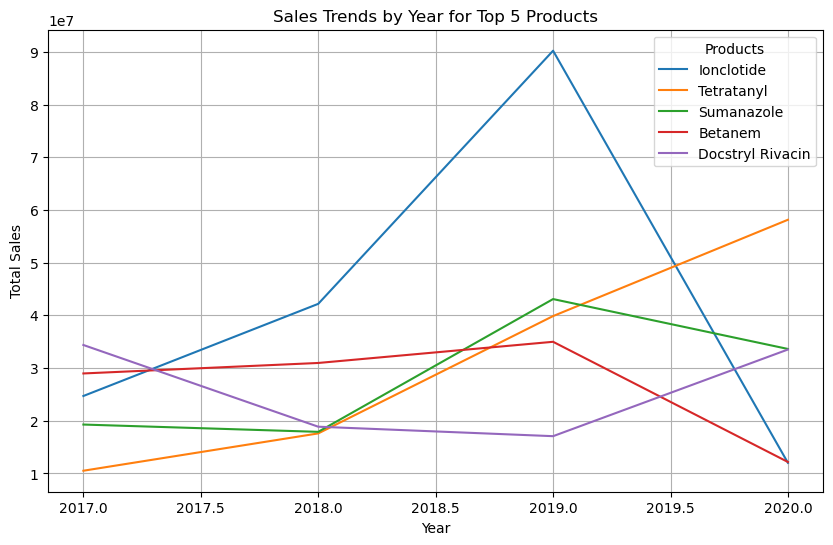

In [12]:
# Plot total sales trends for top 5 products
top_products = sales_by_year_product.groupby("ProductName")["Total_Sales"].sum().nlargest(5).index
filtered_data = sales_by_year_product[sales_by_year_product["ProductName"].isin(top_products)]

plt.figure(figsize=(10, 6))
for product in top_products:
    product_data = filtered_data[filtered_data["ProductName"] == product]
    plt.plot(product_data["Year"], product_data["Total_Sales"], label=product)

plt.title("Sales Trends by Year for Top 5 Products")
plt.xlabel("Year")
plt.ylabel("Total Sales")
plt.legend(title="Products")
plt.grid()
plt.show()

##  Product Performance by Class

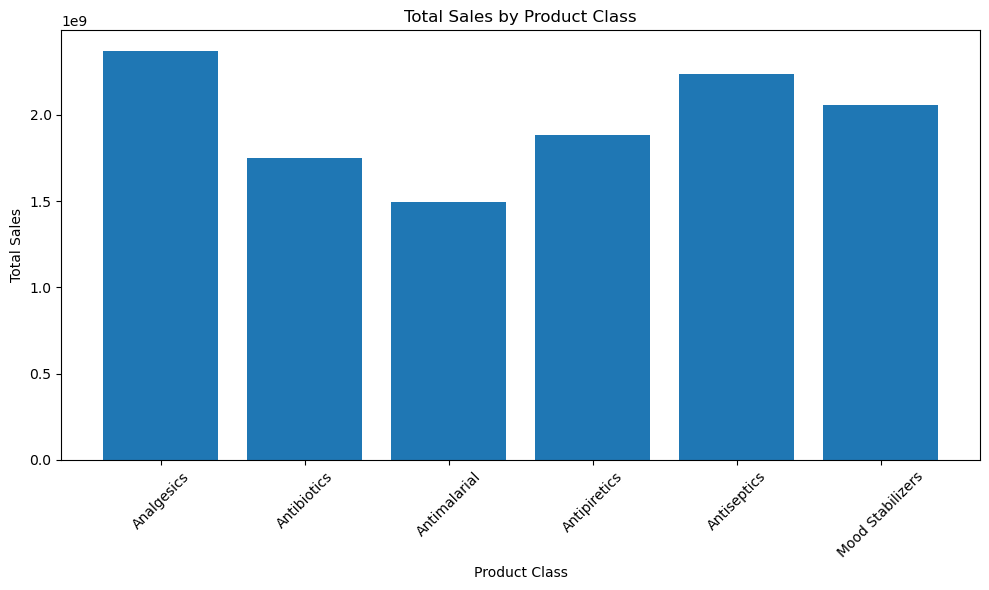

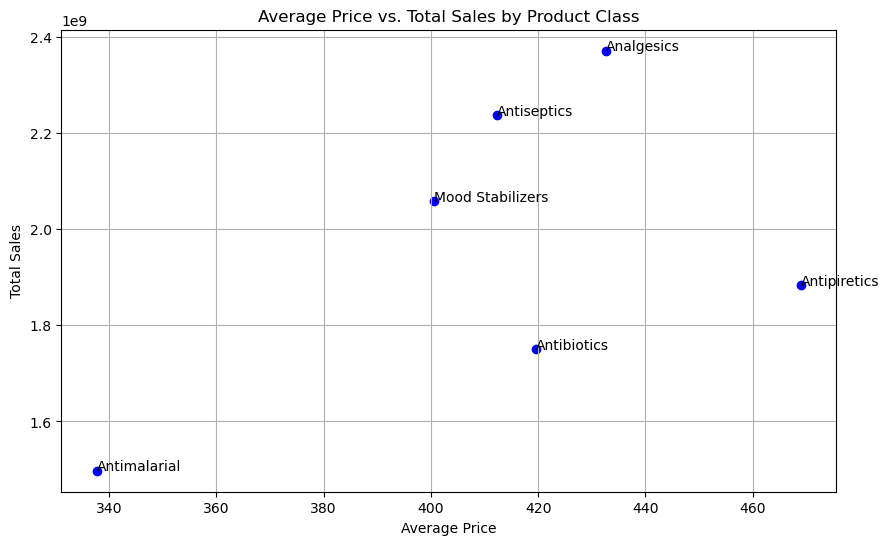

In [13]:
# Bar chart for total sales by product class
plt.figure(figsize=(10, 6))
plt.bar(product_performance["ProductClass"], product_performance["Total_Sales"])
plt.title("Total Sales by Product Class")
plt.xlabel("Product Class")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Scatter plot for average price vs. total sales by product class
plt.figure(figsize=(10, 6))
plt.scatter(product_performance["Average_Price"], product_performance["Total_Sales"], c='blue')
for i, txt in enumerate(product_performance["ProductClass"]):
    plt.annotate(txt, (product_performance["Average_Price"][i], product_performance["Total_Sales"][i]))
plt.title("Average Price vs. Total Sales by Product Class")
plt.xlabel("Average Price")
plt.ylabel("Total Sales")
plt.grid()
plt.show()

##  Product Lifecycle Analysis

In [14]:
# Group by product to find first and last year of sales
product_lifecycle = sales_data.groupby("ProductName").agg(
    First_Year=("Year", "min"),
    Last_Year=("Year", "max"),
    Total_Sales=("Sales", "sum"),
    Total_Quantity=("Quantity", "sum")
).reset_index()

# Add a column to indicate product lifecycle duration
product_lifecycle["Lifecycle_Years"] = product_lifecycle["Last_Year"] - product_lifecycle["First_Year"] + 1

# Categorize products based on lifecycle
current_year = sales_data["Year"].max()
product_lifecycle["Lifecycle_Status"] = product_lifecycle["Last_Year"].apply(
    lambda x: "Emerging" if x == current_year else (
        "Mature" if x - product_lifecycle["First_Year"].mean() >= 3 else "Declining"
    )
)

# Display product lifecycle DataFrame
print("Product Lifecycle Analysis:")
print(product_lifecycle.head())


Product Lifecycle Analysis:
             ProductName  First_Year  Last_Year  Total_Sales  Total_Quantity  \
0           Abatatriptan        2017       2020   74995424.0        101072.0   
1     Abilovir Aprotasol        2017       2020   34146429.6        126938.4   
2             Abobozolid        2017       2020    7426350.0         99018.0   
3  Abranatal Lysoprosate        2017       2020   84577476.0        124196.0   
4                Abtasol        2017       2020   85226882.0        113033.0   

   Lifecycle_Years Lifecycle_Status  
0                4         Emerging  
1                4         Emerging  
2                4         Emerging  
3                4         Emerging  
4                4         Emerging  


## Visualise product lifecycle

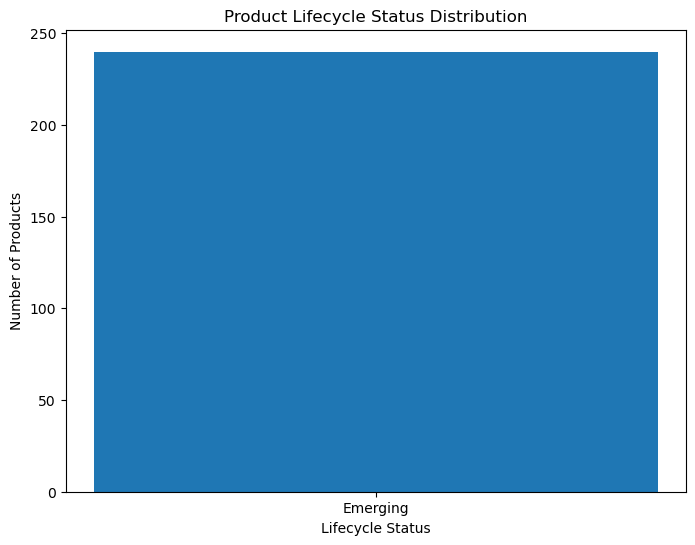

In [16]:
# Bar chart for lifecycle status distribution
lifecycle_status_counts = product_lifecycle["Lifecycle_Status"].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(lifecycle_status_counts.index, lifecycle_status_counts.values)
plt.title("Product Lifecycle Status Distribution")
plt.xlabel("Lifecycle Status")
plt.ylabel("Number of Products")
plt.show()

## Sales Distribution Analysis

In [15]:
# Analyze sales distribution by product class
sales_distribution = sales_data.groupby("ProductClass").agg(
    Total_Sales=("Sales", "sum"),
    Total_Quantity=("Quantity", "sum"),
    Average_Sales=("Sales", "mean"),
    Sales_Proportion=("Sales", lambda x: x.sum() / sales_data["Sales"].sum() * 100)
).reset_index()

# Display sales distribution DataFrame
print("\nSales Distribution Analysis:")
print(sales_distribution.head())


Sales Distribution Analysis:
   ProductClass   Total_Sales  Total_Quantity  Average_Sales  Sales_Proportion
0    Analgesics  2.371515e+09    5.553144e+06   52993.566943         20.099310
1   Antibiotics  1.750277e+09    4.154322e+06   47331.654089         14.834131
2  Antimalarial  1.497455e+09    4.249075e+06   40532.016075         12.691388
3  Antipiretics  1.883306e+09    4.052544e+06   50962.132084         15.961586
4   Antiseptics  2.237525e+09    5.499913e+06   42998.726745         18.963701


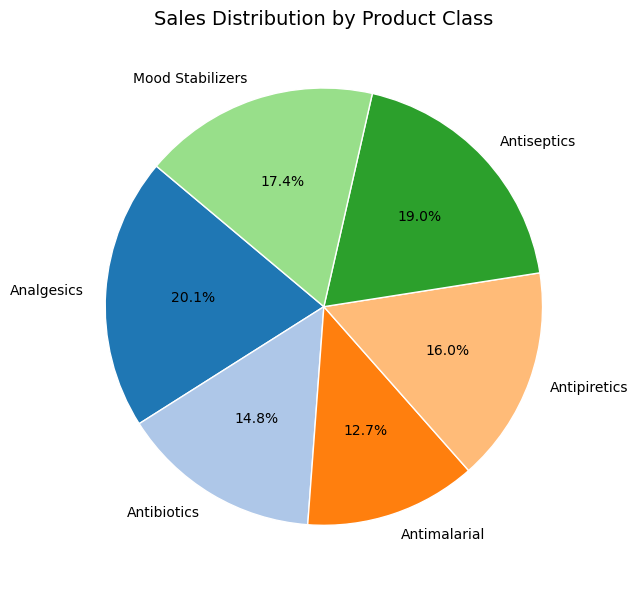

In [19]:
# Pie chart for sales distribution by product class
# Generate a colormap with professional colors
colors = plt.cm.tab20.colors[:len(sales_distribution["ProductClass"])]

# Create the pie chart
plt.figure(figsize=(8, 6))
plt.pie(
    sales_distribution["Sales_Proportion"],
    labels=sales_distribution["ProductClass"],
    autopct='%1.1f%%',
    colors=colors,
    startangle=140,  # Optional: Rotate the start angle for better layout
    wedgeprops={'edgecolor': 'white'}  # Add white edges for clarity
)
plt.title("Sales Distribution by Product Class", fontsize=14)
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

In [ ]:
# top 10 

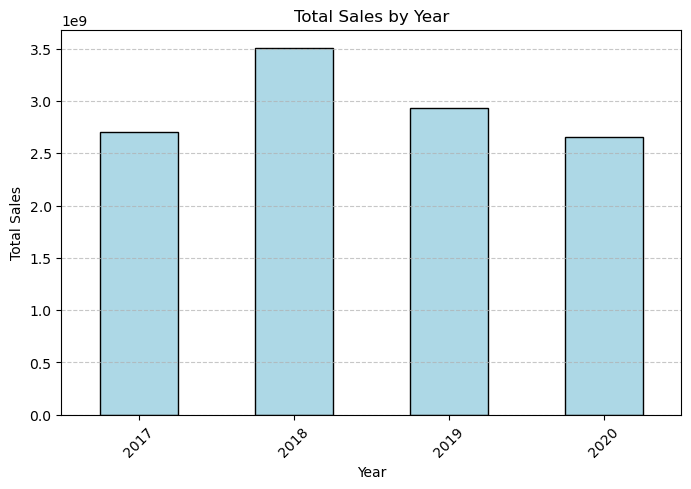

In [8]:
# Total Sales by Year
sales_by_year = sales_data.groupby("Year")["Sales"].sum()

# Plot total sales by year
plt.figure(figsize=(8, 5))
sales_by_year.plot(kind='bar', color='lightblue', edgecolor='black')
plt.title("Total Sales by Year")
plt.xlabel("Year")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

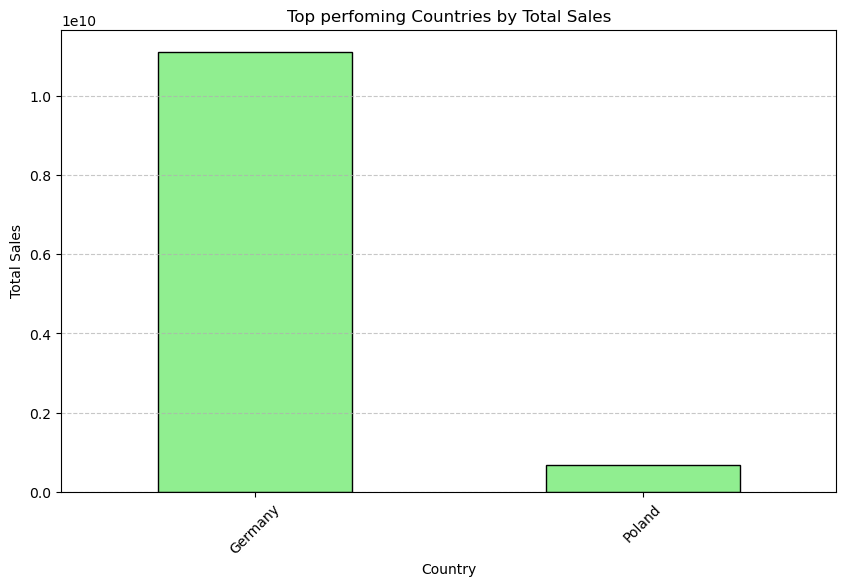

In [18]:
# 2. Sales by Customer Country
# Merge sales data with customer data
sales_with_region = fact_sales_df.merge(dim_customer_df, on="CustomerName", how="left")
sales_by_country = sales_with_region.groupby("Country")["Sales"].sum().sort_values(ascending=False)

# Plot top 10 countries by sales
plt.figure(figsize=(10, 6))
sales_by_country.head(10).plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title("Top perfoming Countries by Total Sales")
plt.xlabel("Country")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

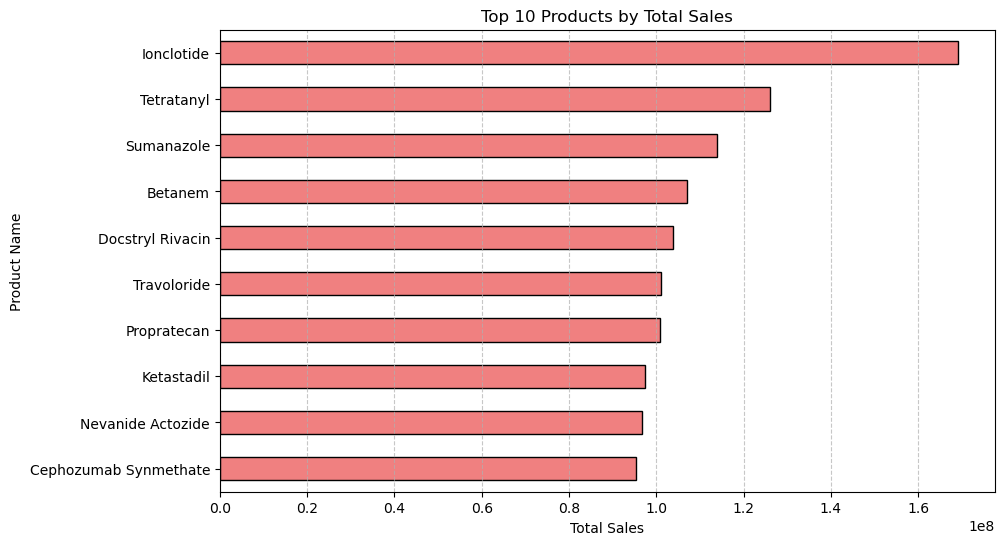

In [17]:
# 3. Sales by Product
product_sales = fact_sales_df.groupby("ProductName")["Sales"].sum().sort_values(ascending=False)

# Plot top 10 products by sales
plt.figure(figsize=(10, 6))
product_sales.head(10).plot(kind='barh', color='lightcoral', edgecolor='black')
plt.title("Top 10 Products by Total Sales")
plt.xlabel("Total Sales")
plt.ylabel("Product Name")
plt.gca().invert_yaxis()  # Invert y-axis for readability
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

## Sales distribution across Products

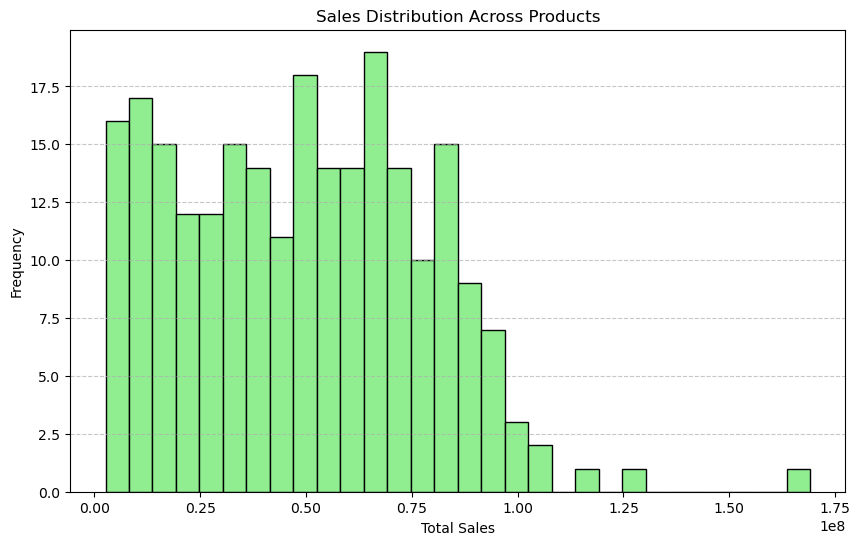

In [19]:
plt.figure(figsize=(10, 6))
product_sales.plot(kind='hist', bins=30, edgecolor='black', color='lightgreen')
plt.title("Sales Distribution Across Products")
plt.xlabel("Total Sales")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()